Here is the list of "low input single cell approximation" (LISCA)
experiments.

* Experiments loaded Information 
  * <a href="#Small-Input-Experiments">Small Input Experiment Table</a>
  * <a href="#Bulk-ENCODE-RNA-Seq-Evaluation-Data">Bulk ENCODE RNA-Seq Evaluation Data</a>
* Plots comparing Correlations
  * <a href="#Naive-Pearson-Comparison">Naive Pearson</a>
  * <a href="#Naive-Spearman-Comparison">Naive Spearman</a>
  * <a href="#Rafa-Pearson-Comparison">Rafa Pearson</a>
  * <a href="#Rafa-Spearman-Comparison">Rafa Spearman</a>
  * <a href="#Rafa-MAD-Comparison">MAD of Log Ratios</a>
  * <a href="#Rafa-SD-Comparison">SD of Log Ratios</a>
* Plots comparing just low input
  * <a href="#Only-Small-Input-Correlations">Correlations</a>
  * <a href="#Small-Input-MAD/SD">MAD and SD of Log Ratios</a>

In [1]:
import pandas
import numpy
import scipy.stats

In [2]:
from curation_common import *

In [3]:
%matplotlib inline
from matplotlib import pyplot
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
server = ENCODED('www.encodeproject.org')
server.load_netrc()

# Functions used later

## Data Loader

In [5]:
def load_fpkms(experiment_files):
    """Load FPKMs out of RSEM results into a pandas dataframe
    
    Columns will be library accession identifiers.
    """
    results = []
    libraries = []
    for i, row in enumerate(experiment_files):
        experiment = str(row['experiment'])
        library = str(row['library'])[-12:-1]
        url = str(row['file_href'])
        fpkms = pandas.read_csv(url, sep='\t', index_col=0, usecols=[0,6])
        libraries.append(library)
        results.append(fpkms)
    df = pandas.concat(results, axis=1)
    df.columns = libraries
    return df

## Correlation computations

In [6]:
def naive_scores(table, rep1_name, rep2_name):
    """Compute Naive correlations for two columns
    """
    rep1 = table[rep1_name]
    rep2 = table[rep2_name]
    scores = pandas.Series({
        'total rows': len(table),
        'passed filter': len(rep1),
        'Pearson': scipy.stats.pearsonr(rep1, rep2)[0],
        'Spearman': scipy.stats.spearmanr(rep1, rep2)[0]
    },
    index = ['total rows', 'passed filter', 'Pearson', 'Spearman']
    )
    return scores

In [7]:
def rafa_scores(table, rep1_name, rep2_name):
    """Compute Rafa's log transformed, filtered correlations and MAD scores
    """
    rep1 = table[rep1_name]
    rep2 = table[rep2_name]
    
    eitherzero = (rep1 == 0) | (rep2 == 0)
    replz1 = numpy.log2(rep1[eitherzero != True])
    replz2 = numpy.log2(rep2[eitherzero != True])
    
    M = replz1 - replz2
    A = (replz1 + replz2) / 2.0

    Acutoff = 0

    scores = pandas.Series({
        'total rows': len(table),
        'passed filter': len(replz1[A > Acutoff]),
        'Pearson': scipy.stats.pearsonr(replz1, replz2)[0],
        'Spearman': scipy.stats.spearmanr(replz1, replz2)[0],
        'MAD': numpy.round(numpy.median(numpy.abs(M)[A > Acutoff]) * 1.4826, 3),
        'SD': numpy.round(numpy.sqrt(numpy.mean(M[A > Acutoff] ** 2)), 3)
    },
    index = ['total rows', 'passed filter', 'Pearson', 'Spearman', 'MAD', 'SD']
    )
    return scores

In [8]:
def compute_all_vs_all_scores(fpkms):
    """Compute all the scores of note for a FPKM table.
    """
    shape = (len(fpkms.columns),len(fpkms.columns))
    s = {
        'Naive Pearson': numpy.zeros(shape),
        'Naive Spearman': numpy.zeros(shape),
        'Rafa Pearson': numpy.zeros(shape),
        'Rafa Spearman': numpy.zeros(shape),
        'Rafa MAD of logratios': numpy.zeros(shape),
        'Rafa SD of logratios': numpy.zeros(shape)
    }
    for i, rep1 in enumerate(fpkms.columns):
        for j, rep2 in enumerate(fpkms.columns):
            scores = naive_scores(fpkms, rep1, rep2)
            rafa = rafa_scores(fpkms, rep1, rep2)
            s['Naive Pearson'][i][j] = scores['Pearson']
            s['Naive Spearman'][i][j] = scores['Spearman']
            s['Rafa Pearson'][i][j] = rafa['Pearson']
            s['Rafa Spearman'][i][j] = rafa['Spearman']
            s['Rafa MAD of logratios'][i][j] = rafa['MAD']
            s['Rafa SD of logratios'][i][j] = rafa['SD']
    return s
        

## Plotting Functions

In [41]:
def heatmap(axes, table, score, title, vmin, vmax, labels=None):
    """Try to intellgently format our heatmap.
    """
    if labels is None:
        columns = table.columns
    else:
        columns = []
        for c in table.columns:
            columns.append(labels[c])
            
    ticks = range(len(table.columns))
    cax = axes.imshow(score, cmap=pyplot.cm.coolwarm, interpolation='none', vmin=vmin, vmax=vmax, origin='lower') 
    cax.axes.set_title(title)
    cax.axes.set_xticks(ticks)
    cax.axes.set_xticklabels(columns, rotation=90)
    cax.axes.set_yticks(ticks)
    cax.axes.set_yticklabels(columns)
    return cax
    

In [106]:
def plot_correlations(bulk_table, bulk_scores, bulk_labels, small_table, small_scores, small_labels, score):
    """Plot scores in the range [0, 1], like correlations.
    """
    fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
    # fig.suptitle(score, fontsize=16)
    pyplot.subplots_adjust(wspace=.4)
    cax = heatmap(ax[0], bulk_table, bulk_scores[score], 'Bulk', 0, 1, bulk_labels)
    cax = heatmap(ax[1], small_table, small_scores[score], 'Small Input', 0, 1, small_labels)
    
    divider = make_axes_locatable(ax[1])
    div_ax = divider.append_axes("right", size="5%", pad=0.05)
    pyplot.colorbar(cax, cax=div_ax)
    
    fig.savefig('/tmp/'+score+'.png')
    fig.savefig('/tmp/'+score+'.svg')


In [107]:
def plot_mad(bulk_table, bulk_scores, bulk_labels, small_table, small_scores, small_labels, score):
    """Plot scores that aren't in the range [0, 1]
    """
    fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
    # fig.suptitle(score, fontsize=16)
    pyplot.subplots_adjust(wspace=.4)
    cax = heatmap(ax[0], bulk_table, bulk_scores[score], 'Bulk', None, None, bulk_labels)
    cax = heatmap(ax[1], small_table, small_scores[score], 'Small Input', None, None, small_labels)

    divider = make_axes_locatable(ax[1])
    div_ax = divider.append_axes("right", size="5%", pad=0.05)
    pyplot.colorbar(cax, cax=div_ax)

    fig.savefig('/tmp/'+score+'.png')
    fig.savefig('/tmp/'+score+'.svg')


# Load Low Input Experiments

In [12]:
libs = [14626, 14629, 14495, 14630, 14627, 14631, 14628, 14632, 14499, 14633, 14501, 14634, 14485, 14486, 14487, 14488, 
        14653, 14654, 14655, 14656, 
        #14665, 14666, 
        14635, 14636
        ]

In [13]:
model = get_model(use_contexts=False)
for l in libs:
    alias = 'barbara-wold:%d' % (l,)
    print(alias)
    libdata = server.get_jsonld(alias)
    load_jsonld_into_model(model, libdata)
    search_results = server.search_jsonld(searchTerm=alias)
    for g in search_results['@graph']:
        if 'experiment' in g['@type']:
            experiment = server.get_jsonld(g['@id'])
            load_jsonld_into_model(model, experiment)


barbara-wold:14626
barbara-wold:14629
barbara-wold:14495
barbara-wold:14630
barbara-wold:14627
barbara-wold:14631
barbara-wold:14628
barbara-wold:14632
barbara-wold:14499
barbara-wold:14633
barbara-wold:14501
barbara-wold:14634
barbara-wold:14485
barbara-wold:14486
barbara-wold:14487
barbara-wold:14488
barbara-wold:14653
barbara-wold:14654
barbara-wold:14655
barbara-wold:14656
barbara-wold:14635
barbara-wold:14636


Loaded experiments

In [14]:
%%sparql -m model -c
select ?exp
where {
  ?exp a experiment:experiment .
}

Found 11 rows.


exp
experiments:ENCSR527RFK/
experiments:ENCSR026ZRP/
experiments:ENCSR861FGB/
experiments:ENCSR510ADJ/
experiments:ENCSR950BNG/
experiments:ENCSR265YFZ/
experiments:ENCSR225BBK/
experiments:ENCSR368QPC/
experiments:ENCSR000OXO/
experiments:ENCSR592MSV/


In [15]:
%%sparql -m model
select ?p ?o
where {
    <https://www.encodeproject.org/labs/barbara-wold/> ?p ?o
}

p,o
rdf:type,https://www.encodeproject.org/profiles/lab.json#lab
rdf:type,https://www.encodeproject.org/profiles/lab.json#item
https://www.encodeproject.org/profiles/lab.json#address1,Department of Biochemistry and Molecular Biophysics
https://www.encodeproject.org/profiles/lab.json#address2,1200 California Blvd; MC156-29
https://www.encodeproject.org/profiles/lab.json#awards,/awards/U54HG006998/
https://www.encodeproject.org/profiles/lab.json#city,Pasadena
https://www.encodeproject.org/profiles/lab.json#country,USA
https://www.encodeproject.org/profiles/lab.json#fax,
https://www.encodeproject.org/profiles/lab.json#institute_label,Caltech
https://www.encodeproject.org/profiles/lab.json#institute_name,California Institute of Technology


Find gene quantifications for the current annotation and group them by genome annotation M4. 

(Hopefully we weren't expecting human....)

In [16]:
%%sparql -m model -c -o experiment_files
select ?experiment ?library ?bioname ?file_href ?output_type ?genome_annotation ?biorep ?techrep
where {
  ?experiment a experiment:experiment ;
              experiment:files ?file .
  ?file file:output_type ?output_type ;
        file:href ?file_href ;
        file:genome_annotation ?genome_annotation ;
        file:replicate ?replicate .
  ?replicate replicate:library ?library ;
             replicate:biological_replicate_number ?biorep ;
             replicate:technical_replicate_number ?techrep .
  ?library library:aliases ?alias ;
           library:biosample ?biosample .
  ?biosample biosample:biosample_term_name ?bioname .  
  filter(regex(?output_type, "gene quantifications"))
  filter(regex(?genome_annotation, "M4"))
}
order by ?experiment ?alias
limit 40


Found 18 rows.


# Small Input Experiments

In [17]:
experiment_files

experiment,library,bioname,file_href,output_type,genome_annotation,biorep,techrep
experiments:ENCSR000OXO/,libraries:ENCLB917PKP/,forebrain,files:ENCFF005TWA/@@download/ENCFF005TWA.tsv,gene quantifications,M4,1,1
experiments:ENCSR000OXO/,libraries:ENCLB026BHP/,forebrain,files:ENCFF550IBS/@@download/ENCFF550IBS.tsv,gene quantifications,M4,2,1
experiments:ENCSR026ZRP/,libraries:ENCLB719BQO/,midbrain,files:ENCFF091FHP/@@download/ENCFF091FHP.tsv,gene quantifications,M4,1,1
experiments:ENCSR026ZRP/,libraries:ENCLB669AEL/,midbrain,files:ENCFF447MON/@@download/ENCFF447MON.tsv,gene quantifications,M4,2,1
experiments:ENCSR265YFZ/,libraries:ENCLB304LFK/,skeletal muscle tissue,files:ENCFF849RFV/@@download/ENCFF849RFV.tsv,gene quantifications,M4,1,1
experiments:ENCSR265YFZ/,libraries:ENCLB096HAH/,skeletal muscle tissue,files:ENCFF021FHW/@@download/ENCFF021FHW.tsv,gene quantifications,M4,2,1
experiments:ENCSR510ADJ/,libraries:ENCLB652HKH/,heart,files:ENCFF408DTF/@@download/ENCFF408DTF.tsv,gene quantifications,M4,1,1
experiments:ENCSR510ADJ/,libraries:ENCLB348BMH/,heart,files:ENCFF393RNC/@@download/ENCFF393RNC.tsv,gene quantifications,M4,2,1
experiments:ENCSR527RFK/,libraries:ENCLB766UOB/,forebrain,files:ENCFF923GRU/@@download/ENCFF923GRU.tsv,gene quantifications,M4,1,1
experiments:ENCSR527RFK/,libraries:ENCLB181TCJ/,forebrain,files:ENCFF235UIN/@@download/ENCFF235UIN.tsv,gene quantifications,M4,2,1


In [18]:
low_fpkms = load_fpkms(experiment_files)

### Report scores for two related experiments

(As a check on correlation computations)

In [19]:
naive_scores(low_fpkms, 'ENCLB917PKP', 'ENCLB026BHP')

total rows       69690.000000
passed filter    69690.000000
Pearson              0.969447
Spearman             0.795169
dtype: float64

In [20]:
rafa_scores(low_fpkms, 'ENCLB917PKP', 'ENCLB026BHP')

total rows       69690.000000
passed filter     7888.000000
Pearson              0.626719
Spearman             0.716698
MAD                  1.344000
SD                   2.453000
dtype: float64

# Load ENCODE Bulk Evaluation Data

In [21]:
rna_model = get_model()
rna_evaluation = server.get_jsonld('https://www.encodeproject.org/datasets/ENCSR000AJW/')
load_jsonld_into_model(rna_model, rna_evaluation)

In [22]:
%%sparql -m rna_model -c -o rna_libraries
select ?library
where {
    ?replicate replicate:library ?library .
}


Found 24 rows.


/usr/lib/python3/dist-packages/RDF.py:2014: RedlandWarning: Variable replicate was bound but is unused in the query
  results = Redland.librdf_query_execute(self._query,model._model)


In [23]:
for row in rna_libraries:
    library = str(row['library'])
    obj = server.get_jsonld(library)
    load_jsonld_into_model(rna_model, obj)

In [39]:
%%sparql -m rna_model -c -o rna_files
select ?labname ?experiment ?library ?bioname ?na_term ?file_href ?output_type ?genome_annotation ?biorep ?techrep
     
where {
  ?experiment a experiment:experiment ;
              experiment:lab ?lab ;
              experiment:files ?file .
  ?file file:output_type ?output_type ;
        file:href ?file_href ;
        file:genome_annotation ?genome_annotation ;
        file:replicate ?replicate .
  ?replicate replicate:library ?library ;
             replicate:biological_replicate_number ?biorep ;
             replicate:technical_replicate_number ?techrep .
  ?library library:biosample ?biosample ;
           library:nucleic_acid_term_name ?na_term .
  ?biosample biosample:biosample_term_name ?bioname .
  ?lab <https://www.encodeproject.org/profiles/lab.json#name> ?labname .
    
  filter(regex(?output_type, "gene quantifications"))
}
order by ?labname ?experiment ?library
limit 40


Found 22 rows.


# Bulk ENCODE RNA-Seq Evaluation Data

In [40]:
rna_files

labname,experiment,library,bioname,na_term,file_href,output_type,genome_annotation,biorep,techrep
barbara-wold,experiments:ENCSR000AEG/,libraries:ENCLB043ZZZ/,GM12878,RNA,files:ENCFF486PVW/@@download/ENCFF486PVW.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEG/,libraries:ENCLB044ZZZ/,GM12878,RNA,files:ENCFF428CJQ/@@download/ENCFF428CJQ.tsv,gene quantifications,V19,2,1
barbara-wold,experiments:ENCSR000AEH/,libraries:ENCLB045ZZZ/,GM12878,polyadenylated mRNA,files:ENCFF745IAF/@@download/ENCFF745IAF.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEH/,libraries:ENCLB046ZZZ/,GM12878,polyadenylated mRNA,files:ENCFF830IVF/@@download/ENCFF830IVF.tsv,gene quantifications,V19,2,1
barbara-wold,experiments:ENCSR000AEP/,libraries:ENCLB061ZZZ/,K562,RNA,files:ENCFF771MAN/@@download/ENCFF771MAN.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEP/,libraries:ENCLB062ZZZ/,K562,RNA,files:ENCFF806RDV/@@download/ENCFF806RDV.tsv,gene quantifications,V19,2,1
barbara-wold,experiments:ENCSR000AEQ/,libraries:ENCLB063ZZZ/,K562,polyadenylated mRNA,files:ENCFF176ACR/@@download/ENCFF176ACR.tsv,gene quantifications,V19,1,1
barbara-wold,experiments:ENCSR000AEQ/,libraries:ENCLB064ZZZ/,K562,polyadenylated mRNA,files:ENCFF456PAW/@@download/ENCFF456PAW.tsv,gene quantifications,V19,2,1
brenton-graveley,experiments:ENCSR000AEE/,libraries:ENCLB039ZZZ/,GM12878,RNA,files:ENCFF009ZXH/@@download/ENCFF009ZXH.tsv,gene quantifications,V19,1,1
brenton-graveley,experiments:ENCSR000AEE/,libraries:ENCLB040ZZZ/,GM12878,RNA,files:ENCFF219RWY/@@download/ENCFF219RWY.tsv,gene quantifications,V19,2,1


In [26]:
rna_fpkms = load_fpkms(rna_files)

In [27]:
naive_scores(rna_fpkms, 'ENCLB035ZZZ', 'ENCLB036ZZZ')

In [28]:
rafa_scores(rna_fpkms, 'ENCLB035ZZZ', 'ENCLB036ZZZ')

# Compute the scores for all libraries vs all libraries

In [29]:
low_scores = compute_all_vs_all_scores(low_fpkms)

In [30]:
rna_scores = compute_all_vs_all_scores(rna_fpkms)

## format meaningful names.

The ENCODE ids are hard to think about. so come up with more meaningful names.

In [49]:
lab_shorten = {
    'barbara-wold': 'wold',
    'brenton-graveley': 'grav',
    'thomas-gingeras': 'ging',
}

na_shorten = {
    'polyadenylated mRNA': 'PolyA',
    'RNA': 'Total'
}

In [61]:
rna_labels = {}
for row in rna_files:
    library = str(row['library'])[-12:-1]
    rna_labels[library] = "{lab} {na} {bio} {rep}".format(
        lab=lab_shorten[str(row['labname'])],
        na=na_shorten[str(row['na_term'])],
        bio=str(row['bioname']),
        rep='r' + str(row['biorep']),
    )

In [65]:
rna_labels

{'ENCLB035ZZZ': 'ging Total GM12878 r1',
 'ENCLB036ZZZ': 'ging Total GM12878 r2',
 'ENCLB037ZZZ': 'ging PolyA GM12878 r1',
 'ENCLB038ZZZ': 'ging PolyA GM12878 r2',
 'ENCLB039ZZZ': 'grav Total GM12878 r1',
 'ENCLB040ZZZ': 'grav Total GM12878 r2',
 'ENCLB041ZZZ': 'grav PolyA GM12878 r1',
 'ENCLB042ZZZ': 'grav PolyA GM12878 r2',
 'ENCLB043ZZZ': 'wold Total GM12878 r1',
 'ENCLB044ZZZ': 'wold Total GM12878 r2',
 'ENCLB045ZZZ': 'wold PolyA GM12878 r1',
 'ENCLB046ZZZ': 'wold PolyA GM12878 r2',
 'ENCLB055ZZZ': 'ging PolyA K562 r1',
 'ENCLB056ZZZ': 'ging PolyA K562 r2',
 'ENCLB057ZZZ': 'grav Total K562 r1',
 'ENCLB058ZZZ': 'grav Total K562 r2',
 'ENCLB059ZZZ': 'grav PolyA K562 r1',
 'ENCLB060ZZZ': 'grav PolyA K562 r2',
 'ENCLB061ZZZ': 'wold Total K562 r1',
 'ENCLB062ZZZ': 'wold Total K562 r2',
 'ENCLB063ZZZ': 'wold PolyA K562 r1',
 'ENCLB064ZZZ': 'wold PolyA K562 r2'}

In [69]:
small_labels = {}
for row in experiment_files:
    library = str(row['library'])[-12:-1]
    small_labels[library] = "{bio} {rep}".format(
        bio=str(row['bioname']),
        rep='r' + str(row['biorep']),
    )

In [70]:
small_labels

{'ENCLB005HHX': 'thymus r1',
 'ENCLB026BHP': 'forebrain r2',
 'ENCLB096HAH': 'skeletal muscle tissue r2',
 'ENCLB181TCJ': 'forebrain r2',
 'ENCLB185MNU': 'thymus r2',
 'ENCLB238LIR': 'hindbrain r1',
 'ENCLB304LFK': 'skeletal muscle tissue r1',
 'ENCLB348BMH': 'heart r2',
 'ENCLB356IIP': 'liver r1',
 'ENCLB449LBZ': 'liver r1',
 'ENCLB652HKH': 'heart r1',
 'ENCLB669AEL': 'midbrain r2',
 'ENCLB719BQO': 'midbrain r1',
 'ENCLB765HDK': 'hindbrain r2',
 'ENCLB766UOB': 'forebrain r1',
 'ENCLB791CRT': 'liver r2',
 'ENCLB905LVV': 'liver r2',
 'ENCLB917PKP': 'forebrain r1'}

# Plot Correlations

## Naive Pearson Comparison

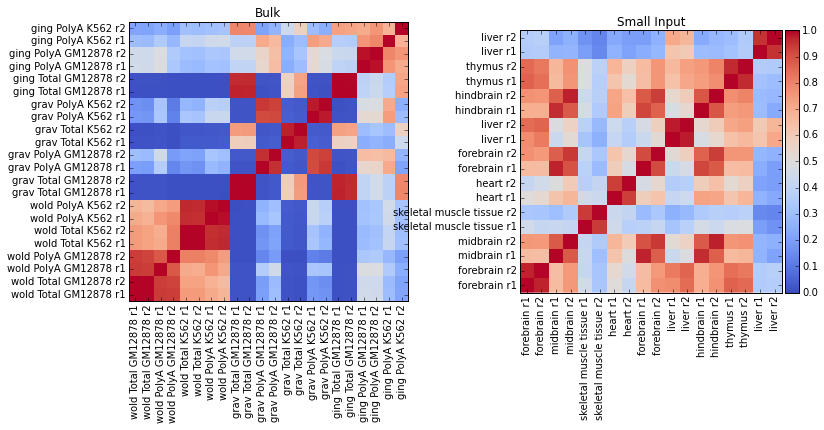

In [108]:
plot_correlations(rna_fpkms, rna_scores, rna_labels, low_fpkms, low_scores, small_labels, 'Naive Pearson')

## Naive Spearmon Comparison

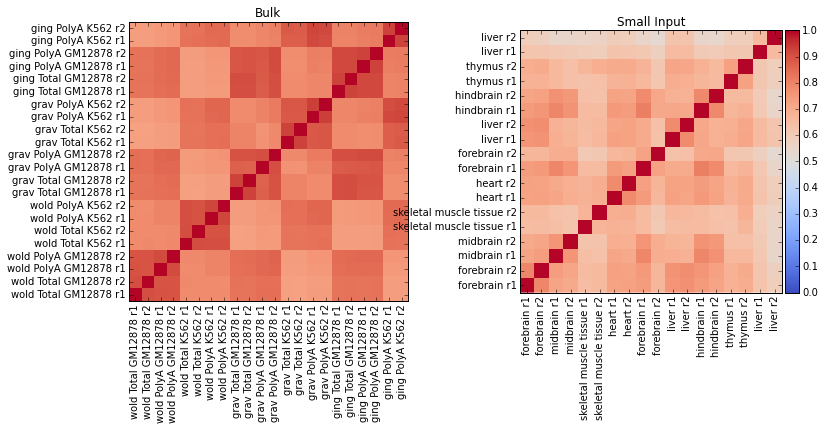

In [109]:
plot_correlations(rna_fpkms, rna_scores, rna_labels, low_fpkms, low_scores, small_labels, 'Naive Spearman')

## Rafa Pearson Comparison

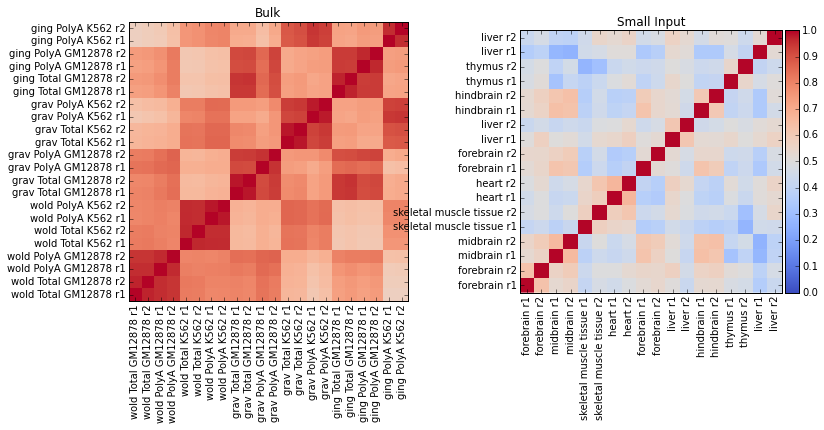

In [110]:
plot_correlations(rna_fpkms, rna_scores, rna_labels, low_fpkms, low_scores, small_labels, 'Rafa Pearson')

## Rafa Spearman Comparison

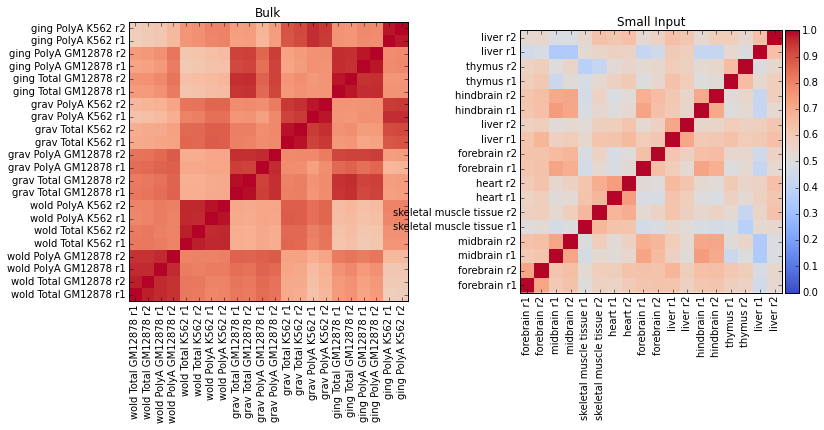

In [111]:
plot_correlations(rna_fpkms, rna_scores, rna_labels, low_fpkms, low_scores, small_labels, 'Rafa Spearman')

# Rafa MAD Comparison

**NOTE** Autoscale

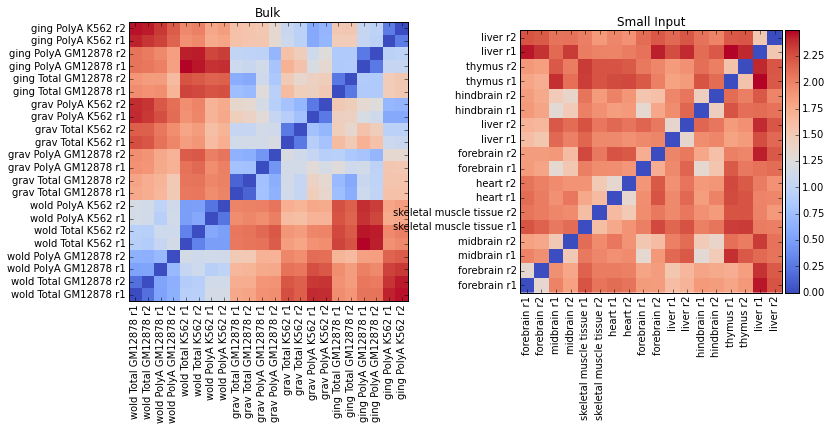

In [112]:
plot_mad(rna_fpkms, rna_scores, rna_labels, low_fpkms, low_scores, small_labels, 'Rafa MAD of logratios')

## Rafa SD Comparison

**Note** Autoscale

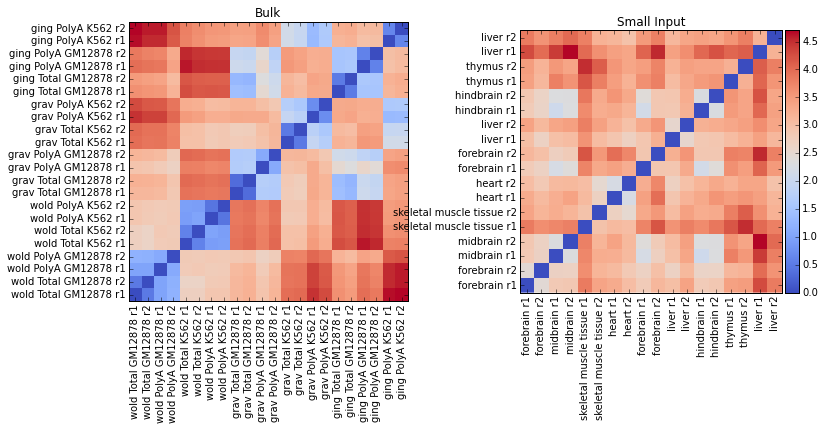

In [113]:
plot_mad(rna_fpkms, rna_scores, rna_labels, low_fpkms, low_scores, small_labels, 'Rafa SD of logratios')

# Only Small Input Correlations

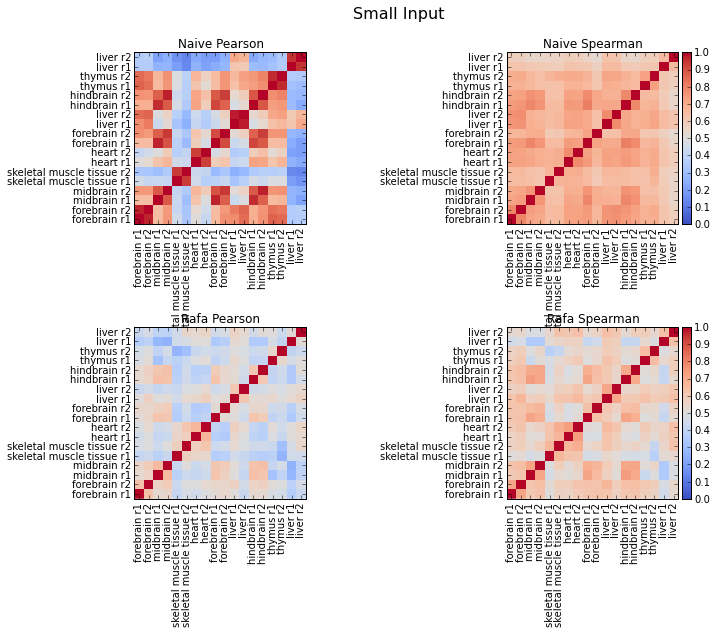

In [114]:
fig, ax = pyplot.subplots(2, 2, figsize=(12,8))
fig.suptitle('Small Input', fontsize=16)
pyplot.subplots_adjust(wspace=.3, hspace=.6)

cax = heatmap(ax[0][0], low_fpkms, low_scores['Naive Pearson'], title='Naive Pearson', vmin=0, vmax=1, labels=small_labels)
cax = heatmap(ax[0][1], low_fpkms, low_scores['Naive Spearman'], title='Naive Spearman', vmin=0, vmax=1, labels=small_labels)

cax = heatmap(ax[1][0], low_fpkms, low_scores['Rafa Pearson'], title='Rafa Pearson', vmin=0, vmax=1, labels=small_labels)
cax = heatmap(ax[1][1], low_fpkms, low_scores['Rafa Spearman'], title='Rafa Spearman', vmin=0, vmax=1, labels=small_labels)

divider = make_axes_locatable(ax[0][1])
div_ax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(cax, cax=div_ax)

divider = make_axes_locatable(ax[1][1])
div_ax = divider.append_axes("right", size="5%", pad=0.05)
pyplot.colorbar(cax, cax=div_ax)

fig.savefig('/tmp/'+'small_corr'+'.png')
fig.savefig('/tmp/'+'small_corr'+'.svg')


## Small Input MAD/SD

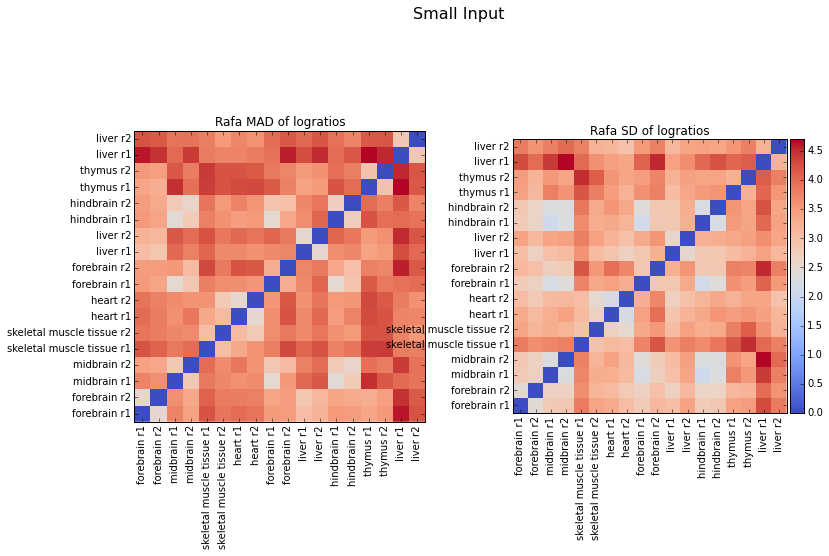

In [116]:
fig, ax = pyplot.subplots(1, 2, figsize=(12,8))
fig.suptitle('Small Input', fontsize=16)
pyplot.subplots_adjust(wspace=.3, hspace=.6)
#'Rafa MAD of logratios', 'Rafa SD of logratios'
cax = heatmap(ax[0], low_fpkms, low_scores['Rafa MAD of logratios'], title='Rafa MAD of logratios', 
              vmin=None, vmax=None, labels=small_labels)
cax = heatmap(ax[1], low_fpkms, low_scores['Rafa SD of logratios'], title='Rafa SD of logratios', vmin=None, vmax=None, labels=small_labels)

divider = make_axes_locatable(ax[1])
div_ax = divider.append_axes("right", size="5%", pad=0.05)

pyplot.colorbar(cax, cax=div_ax)
fig.savefig('/tmp/small_madsd.png')
fig.savefig('/tmp/small_madsd.svg')
